# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


In [464]:
# Parameters
m = 3
A = 0.1449

0.1449

In [465]:
res=m;
N=2.0^m*500.0;#2.0^m*500.0;#N=2.0^m*500.0#2.0^m*100.0;
Xf=1.0;

dx=Xf/N;
dt=round(dx*0.4,digits=10);
Nt=100.0*2^m*10#100.0*2^m*10
Tf=Nt*dt; #final time

println("the final time is ", Tf)

the final time is 0.8


In [466]:
print(N)

4000.0

In [467]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)
println("epsilon <= dx/dt * (1/2)^(2*2-1) = ", dx/dt*(1/2)^(2*2-1))

println("epsilon = dx/dt * (1/2)^(2*2) = ", dx/dt*(1/2)^(2*2))

println("epsilon = dx/dt * (1/2)^(2*3) = ", dx/dt*(1/2)^(2*3))

println("epsilon = dx/dt * (1/2)^(2) = ", dx/dt*(1/2)^(2))

dx =0.00025
dt =0.0001
dx/dt =2.5
epsilon <= dx/dt * (1/2)^(2*2-1) = 0.3125
epsilon = dx/dt * (1/2)^(2*2) = 0.15625
epsilon = dx/dt * (1/2)^(2*3) = 0.0390625
epsilon = dx/dt * (1/2)^(2) = 0.625


In [468]:
# Setting RESOLUTION

global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res$res"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res3"

In [469]:
println(dx)
println(dt)

0.00025
0.0001


In [470]:
epsilon=0.1##0.01#0.05; #05; #02;#0.05; #0.05; #0.05;#0.05;#0.05; #dissipation strength (-1 for backwards integration)

0.1

# Grid

In [471]:
ori=0.0;
initX1 = nothing
initX1=range(ori, stop=Xf, step=dx);

In [472]:
print(dx)
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)

#T=range(dt,stop=Tf,step=dt)
T=range(0,stop=Tf-dt,step=dt)
println("the time step is ", dt)

0.00025step size is  0.00025
the time step is 0.0001


In [473]:
radius=zeros(L)
print(L)
print(size(initX1))
print(initX1[1001])
for i in 1:L
    radius[i]=initX[i]/(1-initX[i])
end

4007(4001,)0.25

In [474]:
include("./ScalarField.jl");

In [475]:
using Interpolations

# Initial data of m β Ψ and Ψ,x

In [476]:
using PyCall   


scipy = pyimport("scipy")
scipyinterpolate = pyimport("scipy.interpolate")


####

initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initderpsi=zeros(L);

state_array=[initm initbeta initpsi initderpsi initX];

#PSI
r0=0.7#0.3
sigma=0.3
initpsi[4:L-3] = init_gaussian(initX1,r0,sigma,A)

state_array[:,3] = initpsi
state_array = ghost(state_array)

#PSI,X FROM PSI
for i in 4:L-3
    initderpsi[i]=Der(state_array[:,:],i,3,initX)
end

state_array[:,4] = initderpsi
state_array = ghost(state_array)

####

spl_psi = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,3],k=4)
psi_func(x) = scipyinterpolate.splev(x, spl_psi)

spl_derpsi = scipyinterpolate.splrep(initX[4:L-3], initderpsi[4:L-3],k=4)
derpsi_func(x) = scipyinterpolate.splev(x, spl_derpsi)

funcs = [psi_func derpsi_func]

1×2 Matrix{Function}:
 psi_func  derpsi_func

In [477]:
#BETA
beta0=0
initbeta[4:L-3]=rk4wrapper(SFconstraint_beta,beta0,initX1,0,funcs)
state_array[:,2]=initbeta;
state_array=ghost(state_array);


#M
m0=0
initm[1:L]=rk4wrapper(SFconstraint_beta,m0,initX,0,funcs)#here!!!!!!!!!!!
state_array[:,1]=initm;

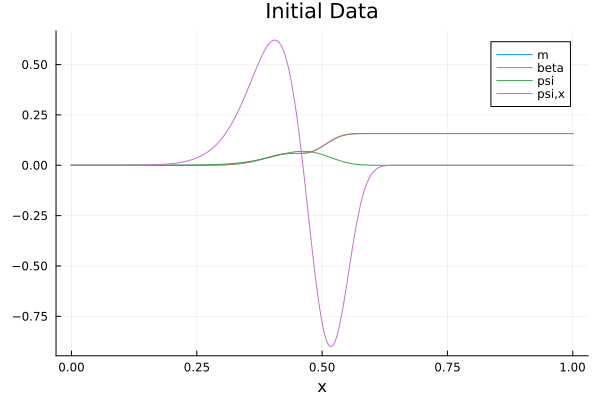

In [478]:
using Plots #showing initial data and the initial status of the horizon finder
plot(initX, state_array[:,1:4], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, xlim=[-0.001, 0.001])

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [479]:
using CSV, Tables
#CSV.write(dir*"/time_step0.csv", Tables.table(transpose(Matrix(state_array))), writeheader=false)
CSV.write(dir*"/time_step0.csv", Tables.table(state_array), writeheader=false)

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res3/time_step0.csv"

In [480]:
k=0
criticality=false
critical_stop=0
evol_stats = [criticality A sigma r0 k]
monitor_ratio = zeros(L)
CSV.write("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv", Tables.table(evol_stats), writeheader=true)

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv"

 ## Time evolution

fixed grid

In [481]:
using Interpolations
using ProgressMeter
@showprogress for k in 1:20#length(T)
    
    if isnan(state_array[L-3,4])
        print("boom")
        break
    end
    
    
    X=state_array[:,5]
    X1=X[4:L-3]
    
    #update ghost points
    #state_array=boundarySF(state_array,X)
   
    #evolve psi,x
    state_array[:,1:4] = rungekutta4molstep(SF_RHS,state_array[:,1:4],T,k,0,derpsi_func,X) #evolve psi,x
    state_array=ghost(state_array)

    #global aux=SF_RHS(state_array[:,:], 0,0,X)
    
    #calculate psi from psi,x
    spl_derpsi = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,4],k=5)
    SFconstraint_psi(psi0,x) = scipyinterpolate.splev(x, spl_derpsi)
    psi0=0
    state_array[4:L-3,3] = rungekutta4(SFconstraint_psi,psi0,initX1)
    state_array=ghost(state_array);

    spl_psi = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,3],k=4)
    psi_func(x) = scipyinterpolate.splev(x, spl_psi)

    funcs = [psi_func derpsi_func]
    #psi_double_data = rungekutta4(SFconstraint_psi,psi0,doublegrid(X1))
    
    #evolve beta
    beta0=0
    state_array[4:L-3,2]=rk4wrapper(SFconstraint_beta,beta0,X1,0,funcs)
    state_array=ghost(state_array)
    
    #evolve m
    m0=0
    state_array[4:L-3,1]=rk4wrapper(SFconstraint_beta,m0,X1,0,funcs)#here
    state_array=ghost(state_array)
    
    #CSV.write(dir*"/time_step$k.csv", Tables.table(transpose(Matrix(state_array))), writeheader=false)
    CSV.write(dir*"/time_step$k.csv", Tables.table(state_array), writeheader=false)
    
    
    #threshold for apparent black hole formation
    monitor_ratio = zeros(L)
    for i in 1:L
        monitor_ratio[i] = 2*state_array[i,1]/initX[i]*(1-initX[i])
        if monitor_ratio[i]>0.6
            global criticality = true
            println("Supercritical evolution!")
            println("i = ", i, " k = ", k, " monitor ratio = ", monitor_ratio[i])
            global critical_stop += 1
        end
    end
    
    if critical_stop >=15
        print("Found apparent horizon formation")
        break
    end
end

evol_stats = [criticality A sigma r0 k]

CSV.write("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv", Tables.table(evol_stats), writeheader=true)

CSV.write("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv", Tables.table(transpose(Array(monitor_ratio))), delim = ';', writeheader=false, append=true)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv"

In [211]:
bb=zeros(L)
for i in 4:L-3
    bb[i]=Der(state_array[:,:],i,1,initX)
end
bb=ghost(bb)

4007-element Vector{Float64}:
  1.4628651992127143e-14
  4.676630568331509e-14
  5.271116251482425e-14
  4.347863679237522e-14
  3.008414282168861e-14
  2.3543094908485024e-14
  3.487090735848508e-14
  6.491818404222057e-14
  1.0287801162311648e-13
  1.5056395890508127e-13
  2.1007625678294366e-13
  2.831328783875279e-13
  3.7125901501818846e-13
  ⋮
  3.1456319031049566e-12
  2.710794551792185e-12
  2.3222164931745416e-12
  1.9706458687098698e-12
  1.5173048003212144e-12
  1.174986034394565e-12
  8.049116928533271e-13
  3.978299171573916e-13
 -3.7007434154159526e-14
 -4.903485025422441e-13
 -9.529414294677798e-13
 -1.4155343563916846e-12

In [204]:
aa = SF_RHS(state_array[:,:], 0,0,initX)
aa = ghost(aa)

4007-element Vector{Float64}:
  1.4628651992127143e-14
  4.676630568331509e-14
  5.271116251482425e-14
  4.347863679237522e-14
  3.008414282168861e-14
  2.3543094908485024e-14
  3.487090735848508e-14
  6.491818404222057e-14
  1.0287801162311648e-13
  1.5056395890508127e-13
  2.1007625678294366e-13
  2.831328783875279e-13
  3.7125901501818846e-13
  ⋮
  3.1456319031049566e-12
  2.710794551792185e-12
  2.3222164931745416e-12
  1.9706458687098698e-12
  1.5173048003212144e-12
  1.174986034394565e-12
  8.049116928533271e-13
  3.978299171573916e-13
 -3.7007434154159526e-14
 -4.903485025422441e-13
 -9.529414294677798e-13
 -1.4155343563916846e-12

In [205]:
aa.-bb

4007-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

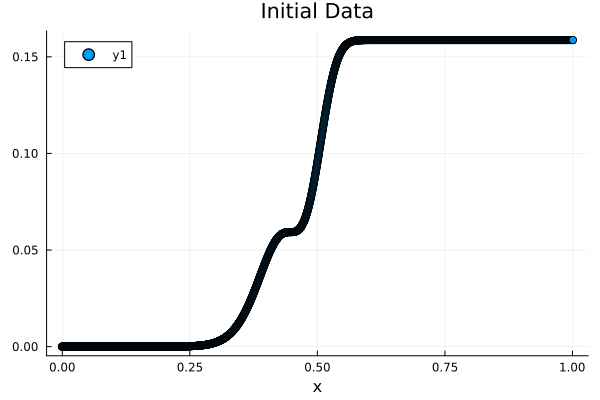

In [213]:
using Plots #showing initial data and the initial status of the horizon finder
scatter(initX, aa, xaxis="x",title="Initial Data")
scatter(initX, state_array[:,1], xaxis="x",title="Initial Data")

In [207]:
cc = zeros(L)
for i in 1:L
    cc[i]=D(state_array[:,:],i,1,initX)
end

In [208]:
cc.-aa

4007-element Vector{Float64}:
 -5.829749108754342e-13
 -2.3512110438511116e-13
 -7.15019013330018e-14
 -1.2238840227989852e-14
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  4.0314277181189297e-13
  2.038134587272319e-12
  6.159245218238097e-12
  1.444630793660071e-11

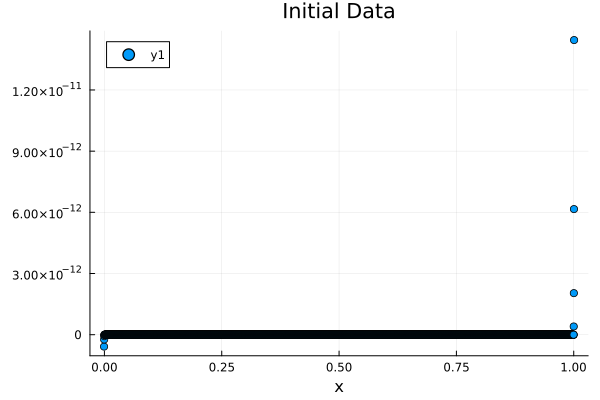

In [212]:
using Plots #showing initial data and the initial status of the horizon finder
scatter(initX, cc.-aa, xaxis="x",title="Initial Data")

In [ ]:
using Plots #showing initial data and the initial status of the horizon finder
scatter(initX, ghost(aux).- ghost(initm), xaxis="x",title="Initial Data")

In [ ]:
println(ghost(aux)[500])
println(ghost(initm)[500])

In [ ]:
state_array[:,1] .- ghost(initm)

In [ ]:
(aux[:,3] .- ghost(initpsi))[L]

## Movie of the evolution

In [ ]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 1:1:974#00:2:length(T)-1
    time_step=T[n+1]-T[n];
    IJulia.clear_output(true)
    functions3=DataFrame(CSV.File(dir*"/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
    d=round(T[n],digits=1)
    plot!(initX[4:L-3], [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"])#, xlim=[0.9 1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 15)

changing grid

In [ ]:
"using Interpolations
using ProgressMeter
@showprogress for k in 1:length(T)

    #evolve grid
    X=update_grid(state_array,dx,T,k,spl_funcs)
    state_array[:,5]=X
    L=length(X)
    X1=X[4:L-3]
    
    #evolve psi,x
    state_array=rungekutta4molstep(SF_RHS,state_array,T,k,0,spl_funcs) #evolve psi,x
    state_array=ghost(state_array,X)
    
    X=state_array[:,5]
    X1=X[4:L-3]
    
    spl_derpsi = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,4],k=4)
    derpsi_func(x) = scipyinterpolate.splev(x, spl_derpsi)
    spl_funcs[4] = derpsi_func
    
    #calculate psi form psi,x
    psi0=0
    SFconstraint_psi(psi0,x) = derpsi_func(x)
    state_array[4:L-3,3] = rungekutta4(SFconstraint_psi,psi0,X1)
    state_array=ghost(state_array,X);
    
    spl_psi = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,3],k=4)
    psi_func(x) = scipyinterpolate.splev(x, spl_psi)
    spl_funcs[3] = psi_func
    
    #evolve beta
    beta0=0
    state_array[4:L-3,2]=rk4wrapper(SFconstraint_beta,beta0,X1,T,spl_funcs)
    state_array=ghost(state_array,X)
    
    spl_beta = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,2],k=4)
    beta_func(x) = scipyinterpolate.splev(x, spl_beta)
    spl_funcs[2] = beta_func
    
    #evolve m
    m0=0
    state_array[4:L-3,1]=m_rk4wrapper(SFconstraint_m,m0,X1,T,spl_funcs)
    state_array=ghost(state_array,X)
    
    spl_m = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,1],k=4)
    m_func(x) = scipyinterpolate.splev(x, spl_m)
    spl_funcs[1] = m_func
    
    CSV.write(dir*"/time_step$k.csv", Tables.table(state_array), writeheader=false)
end"

In [ ]:
print(dir)

In [ ]:
"""#monitor_ratio = 1-v/rexp(-2beta)
monitor_ratio = zeros(L)
for i in 1:L
    monitor_ratio[i] = 2*state_array[i,1]/initX[i]*(1-initX[i])
    if monitor_ratio[i]>0.6
        print(monitor_ratio[i])
    end
end"""